# Prepare Environment
### Load Libraries and dependencies

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns

import os
import gc
from tqdm import tqdm
import time

In [2]:
torch.cuda.empty_cache()
gc.collect()

0

# Set GPU

In [3]:
!nvidia-smi

Fri Apr 26 06:23:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   31C    P5              53W / 420W |   7155MiB / 24576MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0" #select 3090 Super

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# Set the device to GPU if CUDA is available
device = torch.device("cuda" if cuda_available else "cpu")
print(f"Using device: {device}")

if torch.cuda.device_count() >= 2:
    print(f"{torch.cuda.device_count()} GPUs are available")

num_gpus = torch.cuda.device_count()
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    
# Example of moving a tensor to GPU
if cuda_available:
    #Get ID
    gpu_id = torch.cuda.current_device()
    print(f"GPU ID being used: {gpu_id}")

    # Get the name of the current GPU
    gpu_name = torch.cuda.get_device_name(gpu_id)
    print(f"GPU in use is: {gpu_name}")

else:
    print("CUDA is not available. No GPU is being used.")

CUDA available: True
Using device: cuda
GPU 0: NVIDIA GeForce RTX 3090
GPU ID being used: 0
GPU in use is: NVIDIA GeForce RTX 3090


# Load Data

In [6]:
#Read smote data back to nb ad cuda df
X_train = pd.read_parquet("../../capstone_data/archive/SMOTE_train_test_split/X_train_smote.parquet")
y_train = pd.read_parquet("../../capstone_data/archive/SMOTE_train_test_split/y_train_smote.parquet")['label']
X_test = pd.read_parquet("../../capstone_data/archive/SMOTE_train_test_split/X_test_smote.parquet")
y_test = pd.read_parquet("../../capstone_data/archive/SMOTE_train_test_split/y_test_smote.parquet")['label']

print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Standardize numerical Cols

In [7]:
# Scale data
scaler = StandardScaler()


numeric_columns = ['duration', #extremely right skewed
                   'orig_bytes', #extremely right skewed
                   'resp_bytes', #extremely right skewed
                   'orig_pkts', #extremely right skewed
                   'resp_pkts', #extremely right skewed
                   'orig_ip_bytes', ##extremely right skewed
                   'resp_ip_bytes'] #extremely right skewed

#Log transformation for extremely right skewed distributions
constant = 1e-6
X_train[numeric_columns] = X_train[numeric_columns].apply(lambda x: np.log(x + constant))
X_test[numeric_columns] = X_test[numeric_columns].apply(lambda x: np.log(x + constant))

# Transform Data to TensorData and Dataloaders

In [8]:
def df_to_tensor(df):
    "Transform values to float32 and move to cuda device"
    return torch.tensor(df.values, dtype=torch.float32).to(device)

X_train_tensor = df_to_tensor(X_train)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = df_to_tensor(X_test)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Create Tensor datasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Load tensor datasets as dataloaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

#https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html

#### Findings
Epochs:100, batch_size:32, accuracy: 99.17%

In [11]:
%%time

lr = 0.0001 #initialize starting learning rate

#Define model
class BinaryClassifierCNN(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassifierCNN, self).__init__()
        self.layer1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(16 * (num_features // 2), 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)  # Reshape [batch_size, channels, features]
        x = self.pool(self.relu(self.layer1(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Initialize model and move to gpu
model = BinaryClassifierCNN(X_train_tensor.shape[1]).to(device)

#Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

#Initialize LR Scheduler - reduces learning rate based on plateau detection
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3) #if loss does not decrease after three epochs, LR is decreased by a factor of 0.1.


train_losses, val_losses = [], []

#Training function
def train_model(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            #print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item()}')
        train_loss = running_loss / len(train_loader)
        

        # Evaluate on training data for epoch loss and intermediate accuracy
        val_loss, accuracy_train = evaluate_model(model, train_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)
        print(optimizer.param_groups[0]['lr'])

        duration = time.time() - start_time

        print(f'Epoch {epoch+1}, Average Loss: {train_loss}, Last Loss: {loss.item()}, Training Accuracy: {accuracy_train}, Time: {duration:.2f} seconds')


# Evaluation function - works for train_loader and testing_loader
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            outputs = model(data)
            loss = criterion(outputs, labels)  # Calculate loss
            total_loss += loss.item()
            predicted = (outputs > 0).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    average_loss = total_loss / len(loader)  # Compute average loss over all batches
    accuracy = correct / total  # Compute accuracy
    return average_loss, accuracy

# Run training and evaluation
print(f'Batch Size: {batch_size}, Learning Rate: {str(lr)}')
train_model(model, train_loader, num_epochs=100)

Batch Size: 32, Learning Rate: 0.0001
0.0001
Epoch 1, Average Loss: 141.32121592215364, Last Loss: 17.009384155273438, Training Accuracy: 0.7316982947442845, Time: 868.18 seconds
0.0001
Epoch 2, Average Loss: 10.792208403621913, Last Loss: 0.597302258014679, Training Accuracy: 0.7694370390482542, Time: 838.80 seconds
0.0001
Epoch 3, Average Loss: 0.513576426081457, Last Loss: 0.5096282958984375, Training Accuracy: 0.7840654045806349, Time: 837.07 seconds
0.0001
Epoch 4, Average Loss: 0.4725075497898223, Last Loss: 0.3609428405761719, Training Accuracy: 0.709894616605986, Time: 836.68 seconds
0.0001
Epoch 5, Average Loss: 0.4397641075155588, Last Loss: 0.40942883491516113, Training Accuracy: 0.8261763190918909, Time: 832.63 seconds
0.0001
Epoch 6, Average Loss: 0.4136181048859496, Last Loss: 0.3176059126853943, Training Accuracy: 0.8175965121039505, Time: 839.28 seconds
0.0001
Epoch 7, Average Loss: 0.3615636662903822, Last Loss: 0.12806904315948486, Training Accuracy: 0.933175435911079

In [22]:
%%time

#Evaluate model on test data subset
evaluate_model(model, test_loader)

CPU times: user 1min 21s, sys: 11.8 ms, total: 1min 21s
Wall time: 1min 21s


(0.03818621997688989, 0.9918379600913788)

In [14]:
#torch.save(model.state_dict(), 'cnn_model_ACC9918379600913788_LR00001wRELUdecay_BatchSize32.pth')

# Evaluate Model 

In [18]:
#load model if already trained
class BinaryClassifierCNN(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassifierCNN, self).__init__()
        self.layer1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(16 * (num_features // 2), 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)  # Reshape [batch_size, channels, features]
        x = self.pool(self.relu(self.layer1(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
model_path = '../trained_models/cnn_model_ACC9918379600913788_LR00001wRELUdecay_BatchSize32.pth'
model = BinaryClassifierCNN(num_features=15)
model.load_state_dict(torch.load(model_path))
if torch.cuda.is_available():
    model.cuda()
model.eval()

BinaryClassifierCNN(
  (layer1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=112, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
# Set the model to evaluation mode
#model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []
probabilities = []

# No gradient is needed for evaluation
with torch.no_grad():
    for data, target in test_loader:
        # If your data and model are on CUDA, ensure data is also moved to CUDA
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = model(data)
        # Assuming the output is for binary classification and contains logits
        # Apply sigmoid to convert logits to probabilities
        probs = torch.sigmoid(output)
        pred = (probs > 0.5).int()  # Threshold probabilities to create binary predictions

        # Move tensors to CPU and convert them to numpy arrays
        true_labels.extend(target.cpu().numpy())
        predictions.extend(pred.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)
probabilities = np.array(probabilities).flatten()  # Flatten in case probabilities have an extra dimension

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predictions))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99   2195209
         1.0       0.99      0.99      0.99   2194870

    accuracy                           0.99   4390079
   macro avg       0.99      0.99      0.99   4390079
weighted avg       0.99      0.99      0.99   4390079



In [20]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9918379600913788
Precision: 0.991856733453705
Recall: 0.9918377229705905
F1 Score: 0.9918378792402923


# Confusion Matrix

Confusion Matrix:
[[2184032   11177]
 [  24655 2170215]]


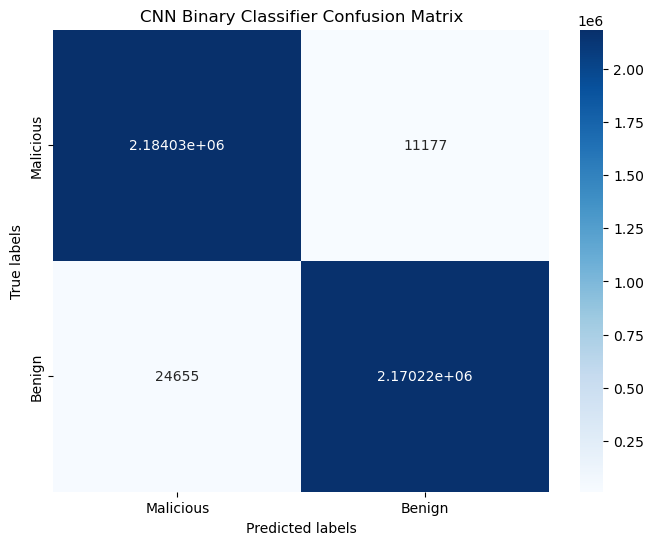

In [21]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Malicious', 'Benign'], yticklabels=['Malicious', 'Benign'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CNN Binary Classifier Confusion Matrix')
plt.savefig('../../Graphs/Conf_Mat/cnn_model_CONF_MAT_ACC9918379600913788_LR00001wRELUdecay_BatchSize32.png')
plt.show()

# ROC Curve

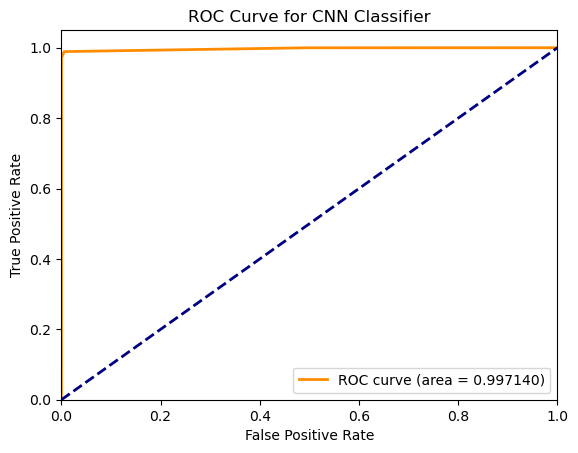

In [22]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN Classifier')
plt.legend(loc="lower right")
plt.savefig('../../Graphs/ROC_CUR/cnn_model_ACC9918379600913788_LR00001wRELUdecay_BatchSize32.png')
plt.show()